# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 7: Evolution of Density Matrix in Hilbert Space using ODE Solver and phenomenological Relaxation
In this tutorial you will see how to evolve the desnity matrix in time by solving Liouville-Von Neumann equation in Hilbert Space for 2 spin half system using ODE Solver. And also we will introduce phenomenological Relaxation. 

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *
from IPython.display import display, Math, Latex

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 9.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [10,50] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-400.22802765 -400.22806765]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


## Zeeman Halitonian in Rotating Frame

In [8]:
OmegaRF = [-System.gammaH1*B0,-System.gammaH1*B0]
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [9]:
"""
Define J Coupling between each spins, Jlist[0][3] means J coupling between 1st spin and 4th spin.
"""

Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 5

Hj = System.Jcoupling(Jlist,Sx,Sy,Sz)

## Pulse

In [10]:
"""
Rotate the magnetization about Y-axis, by an angle theta.
""";
pulse_angle = 90.0
rho = System.Rotate_H(rho_in,pulse_angle,np.sum(Sy,axis=0)) 

## Relaxation Constant

In [11]:
'''
Define longitudinal (R1) and transverse Relaxation (R2)
''';

R1 = 1.0
R2 = 2.0
System.Relaxation_Constants(R1,R2)

'''
Options for "Rprocess": "No Relaxation" or "Phenomenological" 
                         or "Random Field Fluxtuation" or "Dipolar"
''';
Rprocess = "Phenomenological"

## Phenomenological Relaxation Matrix
The simple way to introduce relaxation mechanism into Liouville-Von Neumann equation by introducing a phenomenological relaxation matrix.
The matrix elements consist of R1 at diagonal (make the population to thermal equlibrium) and R2 off-diagonal (kill all types of coherences). 

In [12]:
'''
Representation of Phenomenological Realxation Matrix
''';
R = System.Relaxation_Phenomenological(R1,R2)
Matrix(R)

Matrix([
[1.0, 2.0, 2.0, 2.0],
[2.0, 1.0, 2.0, 2.0],
[2.0, 2.0, 1.0, 2.0],
[2.0, 2.0, 2.0, 1.0]])

<IPython.core.display.Javascript object>


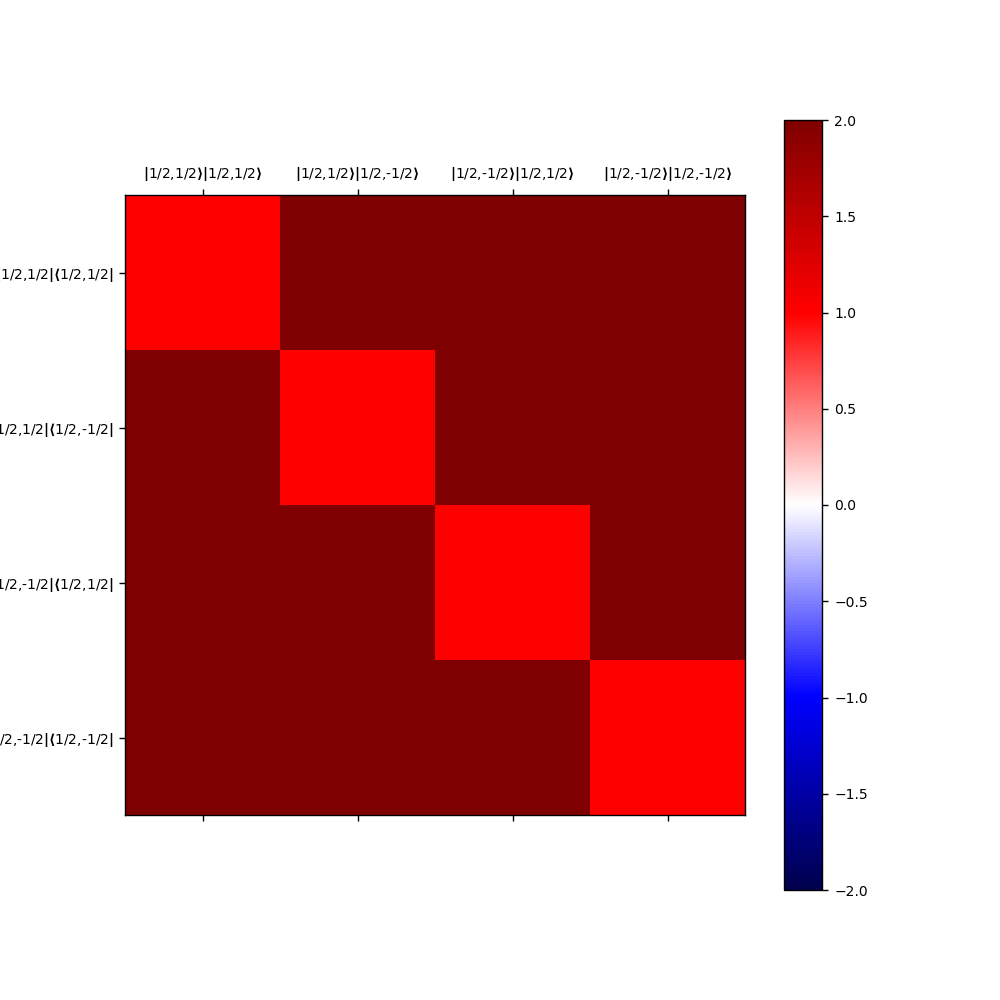

In [13]:
'''
Representation of Phenomenological Realxation Matrix
''';
System.MatrixPlot(1,R.real)

In [14]:
'''
Liouville-Von Neumann equation
H is the Hamiltonian
R is the Phenomenological Realxation Matrix
'''
display(Math(r'\frac{d}{dt} \rho = -\frac{i}{\hbar} [H,\rho] + R (\rho - \rho_{eq})'))

<IPython.core.display.Math object>

## Solving Liouville-Von Neumann equation as System of Ordinary Differential Equations (ODEs)
In previous tutorial we saw the evolution of density matrix using the solution of Liouville-Von Neumann equation. 
But here we solve the Liouville-Von Neumann equation, treating it as system of ordinary differentail equations. 
__This method is slower than previous method (I need to work on the optimization of this method) but it has some positives. You can do relaxation in Hilbert space and no need to go Liouville space, where the matrices (operators) become "fat".__

## Evolution of Density Matrix

In [15]:
"""
Samplling Rate, fs = n * Highest_Larmor_Frequency; minimum value of n = 2 (Nyquist–Shannon sampling theorem)
Dwell time, dt = 1/fs
Acquisition time, AQ is time for which we evolve the density matrix, in seconds.
Number of points in the simulation, Npoints
""";
Highest_Larmor_Frequency = 50.0
fs = 8 * Highest_Larmor_Frequency
dt = 1.0/fs
AQ = 5.0
Npoints = int(AQ/dt)
print("Number of points in the simulation", Npoints)

"""
option for solver, "method": "Unitary Propagator" or "ODE Solver"
"""
method = "ODE Solver"

start_time = time.time()
t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Npoints,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 2000
Total time = 4.0794806480407715 seconds 


## Expectation value

In [16]:
"""
Lets see the expectation value of I1+, I2+,...,I6+ 
""";

EXP = np.sum(Sx,axis=0) + 1j * np.sum(Sy,axis=0) # Transverse Magnetization
EXP_Z = np.sum(Sz,axis=0) # Longitudinal Magnetization

t, Mt = System.Expectation_H(rho_t,EXP,dt,Npoints)
t, Mz = System.Expectation_H(rho_t,EXP_Z,dt,Npoints)

## Fourier Transform

In [17]:
fs = 1.0/dt
freq, spectrum = System.FourierTransform(Mt,fs,5)

## Plotting

<IPython.core.display.Javascript object>


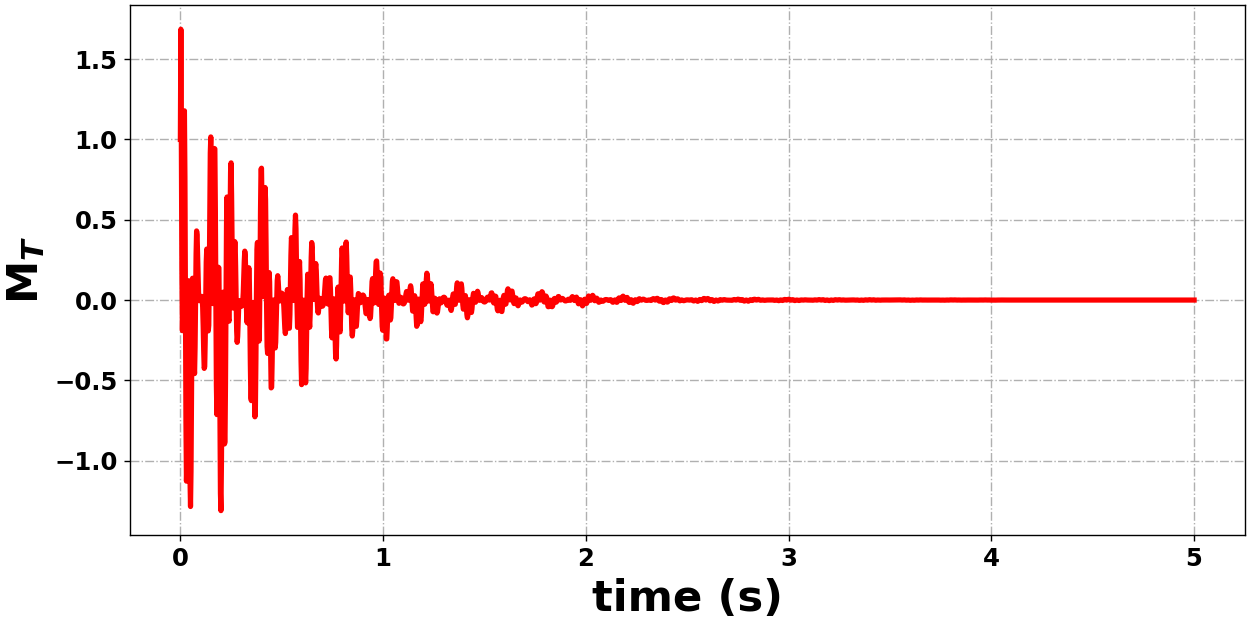

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [18]:
System.Plotting(3,t,Mt,"time (s)",R"M$_{T}$","red")

<IPython.core.display.Javascript object>


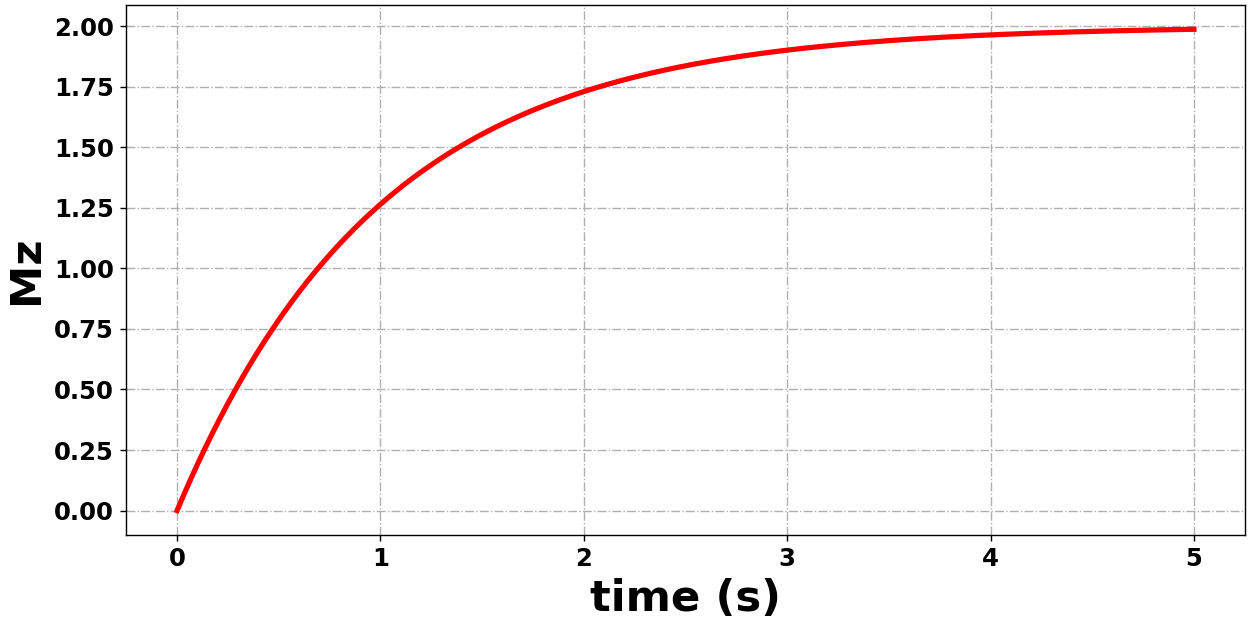

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [19]:
System.Plotting(4,t,Mz,"time (s)","Mz","red")

<IPython.core.display.Javascript object>


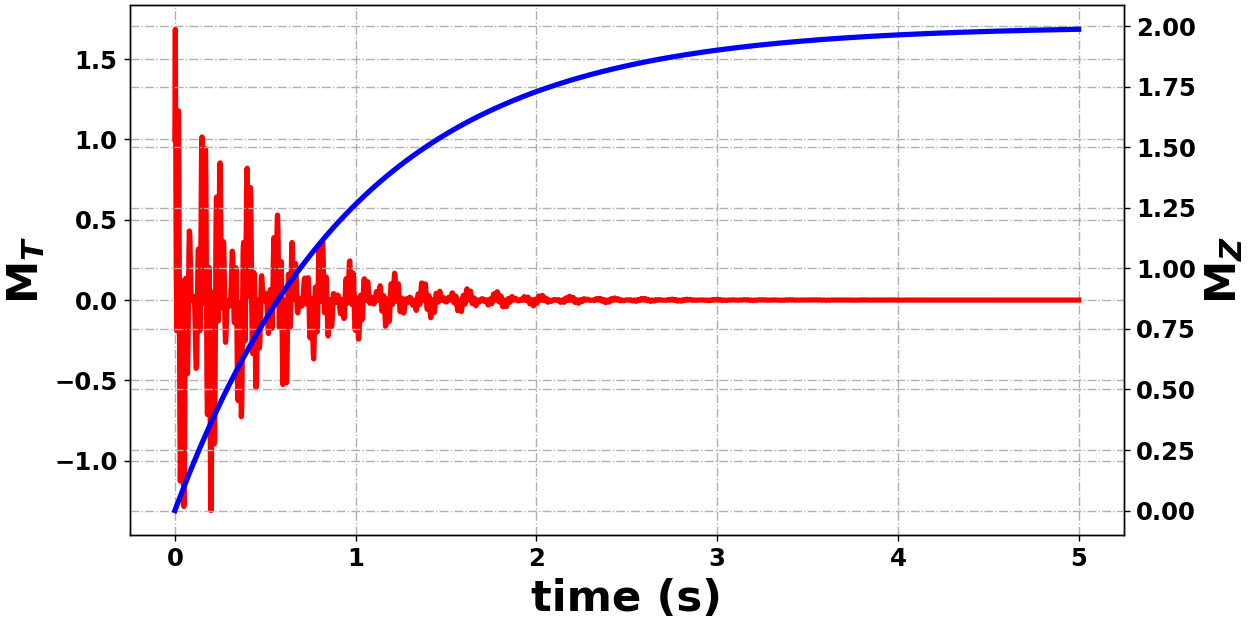

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [20]:
System.PlottingTwin(5,t,Mt,Mz,"time (s)",r"M$_{T}$",r"M$_{Z}$","red","blue")

<IPython.core.display.Javascript object>


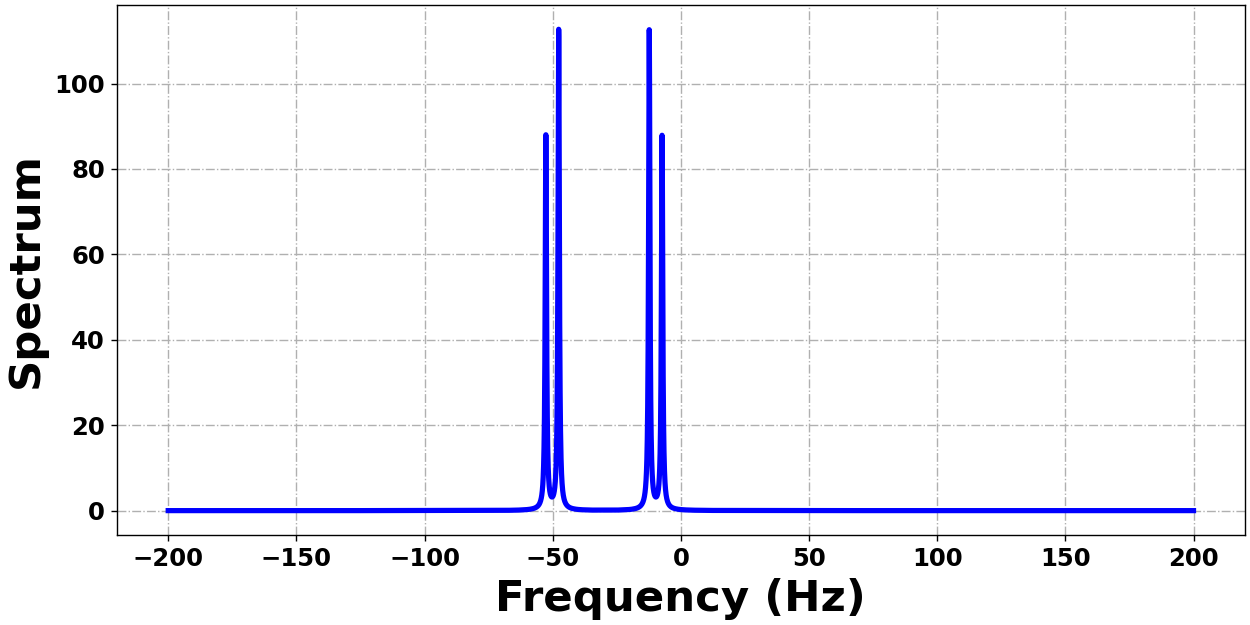

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [21]:
System.Plotting(6,freq,spectrum,"Frequency (Hz)","Spectrum","blue")

## Next tutorial: INEPT

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com